# Дослідження збіжності точності похибки і оптимального розвязку для параметрів розкладу і в загальному для розвязку дерева.

Спробуємо систематизувати ключові параметри котрі мають вплив на точність\час розвязку:

In [1]:
import riversim

print(riversim.MeshParams())

{
    "exponant": 1.0,
    "ignored_smoothness_length": 0.05,
    "max_area": 100000.0,
    "max_edge": 1.0,
    "min_angle": 32.0,
    "min_area": 6e-07,
    "min_edge": 8e-12,
    "ratio": 2.3,
    "refinment_radius": 0.005,
    "sigma": 1.9,
    "smoothness_degree": 0.5
}


In [11]:
print(riversim.SolverParams())

{
    "adaptive_refinment_steps": 0,
    "field_value": 1.0,
    "max_distance": 0.002,
    "num_of_iterrations": 6000,
    "quadrature_degree": 3,
    "refinment_fraction": 0.1,
    "renumbering_type": 0,
    "static_refinment_steps": 0,
    "tollerance": 1e-12
}


In [12]:
print(riversim.IntegrationParams())

{
    "exponant": 2.0,
    "integration_radius": 0.03,
    "weigth_func_radius": 0.01
}


## Базові функції для розвязку поля і малювання

In [1]:
import riversim
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import integrate

In [2]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

def plot(fig, ax, model, figsize = [40, 40]):

    ax.set_aspect('equal')

    plt.rcParams['figure.figsize'] = [40, 40]
    
    ax.cla()
    
    for river_pr in model.rivers:
        x = ([v.x for v in river_pr.data().vertices])
        y = ([v.y for v in river_pr.data().vertices])
        ax.plot(x, y)

    xmin = 0
    xmax = 0
    ymin = 0
    ymax = 0
    for boundary_pr in model.region:
        x = ([v.x for v in boundary_pr.data().vertices])
        y = ([v.y for v in boundary_pr.data().vertices])
        x.append(boundary_pr.data().vertices[0].x)
        y.append(boundary_pr.data().vertices[0].y)
        if min(x) < xmin:
            xmin = min(x)
        if max(x) > xmax:
            xmax = max(x)
        if min(y) < ymin:
            ymin = min(y)
        if max(y) > ymax:
            ymax = max(y)
        ax.plot(x, y)

    ax.set_xlim(xmin - 0.1, xmax + 0.1)
    ax.set_ylim(ymin - 0.1, ymax + 0.1)
    #plt.xlim(xmin - 0.1, xmax + 0.1)
    #plt.ylim(ymin - 0.1, ymax + 0.1)
    #plt.show()
    display(fig)
    clear_output(wait = True)
    #plt.pause(0.001)

In [5]:
import riversim
import time
def solve(model):

    model.rivers[1].addPoint(riversim.Polar(model.ds, 0), 0)

    boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, model.river_width, model.mesh_params.smoothness_degree, model.mesh_params.ignored_smoothness_length)
    triangle = riversim.Triangle(model.mesh_params)
    triangle.mesh_params.tip_points = model.rivers.tipPoints()

    mesh = triangle.generate(boundary, model.region.holes)

    solver = riversim.Solver(model.solver_params, True)
    
    solver.openMesh(mesh)
    for i in range(1 + model.solver_params.adaptive_refinment_steps):
        if i > 0:
            solver.refineGrid()
        solver.setupSystem()
        solver.assembleSystem(model.boundary_conditions)
        solver.solve()
    
    return solver

In [6]:
import numpy as np

model = riversim.Model()
model.initializeDirichlet()
start = time.time()
solution = solve(model)
end = time.time() - start

n = 8
m = 3000
tip_angle = model.rivers[1].tipAngle()
tip_coord = model.rivers[1].tipPoint()
series_params_orig = solution.integrate_new(model.integr_params, tip_coord, tip_angle)

    
integral = [0, 0, 0]
normalization = [0, 0, 0]
drho = model.integr_params.integration_radius / n
for rho in np.arange(drho, model.integr_params.integration_radius, drho):
    weight_func_value = model.integr_params.weightFunction(rho)
    for phi in np.arange(0, 2 * np.pi, np.pi / m / rho * model.integr_params.integration_radius):
        cylind_coord = riversim.Polar(rho, phi)
        abs_coord = riversim.Point(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle))
        rel_coord = abs_coord - tip_coord
        try:
            sol_value = solution.value(abs_coord)
        except:
            continue

        for param_index in range(3):
            base_vector_value = model.integr_params.baseVectorFinal(param_index + 1, tip_angle, rel_coord.x, rel_coord.y);
            integral[param_index] += sol_value * weight_func_value * base_vector_value * rho
            normalization[param_index] += weight_func_value * np.power(base_vector_value, 2) * rho

series_params_my = [integ / norm for integ, norm in zip(integral, normalization)]
solution.outputResults("integral_research")

res = {"averageSolverError": solution.averageCellError(),
        "maxSolverError": solution.maxCellError(), 
        "seriesParamsOrig": [series_params_orig[0], series_params_orig[1], series_params_orig[2]],
        "seriesParamsMy": series_params_my, 
        "dof": solution.numberOfDOFs(),
        "numberOfCells": solution.numberOfCells(), 
        "solverTime": end}
print(res)

{'averageSolverError': 3.429030758237908e-05, 'maxSolverError': 0.0002720710472203791, 'seriesParamsOrig': [0.0355792122765863, 0.007269136353393273, 0.9777641698219764], 'seriesParamsMy': [0.03557961305658218, 0.007268354292693458, 0.9779525997917677], 'dof': 6295, 'numberOfCells': 687, 'solverTime': 0.09706306457519531}


## Розклад поля в ряд в околиці джерела

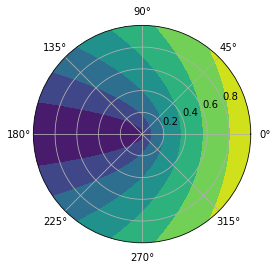

In [4]:
azimuths = np.radians(np.linspace(-180, 180, 360))
zeniths = np.arange(0, 1, 0.0001)

r, theta = np.meshgrid(zeniths, azimuths)

a1 = 1
a2 = 0
a3 = 0
values = a1 * np.sqrt(r) * np.cos(theta/2) + a2 * r * np.sin(theta) + a3 * np.power(r, 3/2) * np.cos(3*theta/2)

#-- Plot... ------------------------------------------------
fig, ax = plt.subplots(subplot_kw = dict(projection='polar'))
ax.contourf(theta, r, values)

plt.show()

## Дослідження модифікації сітки для покращення точності розязку.

Мотивація була така, що при дослідженні точності параметрів розкладу зі збільшенням тточності інтегрування було виявлено, що розязок досиьб повільно збігається до границі і пилкоподібно. Хоч і потім зясувалося, що це було повязанао із алгоритмом інтеграції. Котрий складався із трапеції по кутах і звичайного додавання по радіусу.

#### Зікра довкола точки

In [ ]:
import riversim
import numpy as np

model = riversim.Model()
model.initializeDirichlet()
model.rivers[1].addPoint(riversim.Polar(0.1, 0), 0)
star_around_tip_boundary = riversim.Boundary()
tip_angle = model.rivers[1].tipAngle()
tip_coord = model.rivers[1].tipPoint()
r = model.integr_params.integration_radius
n = 24
for i in range(n):
    star_around_tip_boundary.vertices.extend([\
        tip_coord + riversim.Point( \
            r / 1000. * np.cos(i / n * 2 * np.pi + tip_angle), \
            r / 1000. * np.sin(i / n * 2 * np.pi + tip_angle)),\
        tip_coord + riversim.Point( \
            r * np.cos(i / n * 2 * np.pi + tip_angle), \
            r * np.sin(i / n * 2 * np.pi + tip_angle))])
    star_around_tip_boundary.lines.append(riversim.Line( 2*i, 2*i + 1, -1))

boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, 0.001, 0, 0)
boundary.append(star_around_tip_boundary)

In [ ]:
triangle = riversim.Triangle(model.mesh_params)
triangle.mesh_params.tip_points = model.rivers.tipPoints()

mesh = triangle.generate(boundary, model.region.holes)
mesh.write("trapezoid_test_with_star.msh")

In [ ]:
model.solver_params.quadrature_degree = 4
model.solver_params.adaptive_refinment_steps = 3
solver = riversim.Solver(model.solver_params, True)
solver.openMesh(mesh)
for i in range(1 + model.solver_params.adaptive_refinment_steps):
    print(i)
    if i > 0:
        solver.refineGrid()
    solver.setupSystem()
    solver.assembleSystem(model.boundary_conditions)
    solver.solve()

solver.outputResults("trapezoid_test_with_star")

0
1
2
3


In [ ]:
n_rho = range(1, 30, 1)
model.integr_params.eps = 4e-3
a = [solver.integrate_trap(model.integr_params, tip_coord, tip_angle) for model.integr_params.n_rho in n_rho]

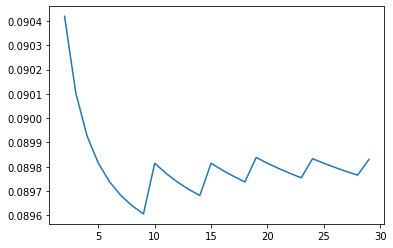

In [ ]:
import matplotlib.pyplot as plt
a1 = [el[0] for el in a]
plt.plot(n_rho, a1)

Проблема залишилася.. отже це мабуть повязано не з мешом, а з самим алгоритмом інтеграції..

Знизу приклад збіжності по eps в інтеграції трикутником

In [ ]:
eps = [1e-2, 5e-3, 1e-3, 5e-4]
model.integr_params.n_eps = 10
a3 = [solver.integrate_trap(model.integr_params, tip_coord, tip_angle)[2] for model.integr_params.eps in eps]

[]

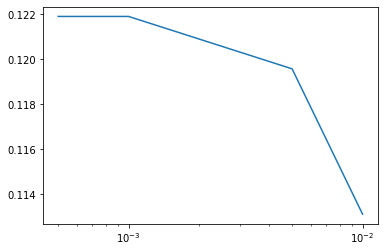

In [ ]:
import matplotlib.pyplot as plt
plt.plot(eps, a3)
plt.semilogx()

## Використання засобів SciPy для інтегралу котрий обчислює параметри розкладу.

### Gauss Quadrature

In [5]:
integrate.dblquad(lambda rho, phi: np.sqrt(rho) * np.cos(phi/2), 0., 2. * np.pi, 0., 0.798, epsabs=1e-10)

(8.086853619526813e-18, 2.1007740919795597e-14)

### Заготовка до роботи. Тобто обчислене поле.

In [8]:
model = riversim.Model()
model.initializeDirichlet()
solution = solve(model)

tip_angle = model.rivers[1].tipAngle()
tip_coord = model.rivers[1].tipPoint()

series_params_orig = solution.integrate_new(model.integr_params, tip_coord, tip_angle)
print(series_params_orig)

[
    0.0906574888281114,
    0.057802788358728034,
    0.11243172053173604
]


In [9]:
integral = [0, 0, 0]
normalization = [0, 0, 0]
integral_l = 0
normalization_l = 0
integral_l_func = lambda rho, phi:  solution.valueSafe(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle)) * model.integr_params.weightFunction(rho) * model.integr_params.baseVectorFinal(2, tip_angle, rho * np.cos(phi + tip_angle), rho * np.sin(phi + tip_angle)) * rho
normalization_l_func = lambda rho, phi:  model.integr_params.weightFunction(rho) * np.power(model.integr_params.baseVectorFinal(2, tip_angle, rho * np.cos(phi + tip_angle), rho * np.sin(phi + tip_angle)), 2) * rho
drho = model.integr_params.integration_radius / 8
for rho in np.arange(drho, model.integr_params.integration_radius, drho):
    weight_func_value = model.integr_params.weightFunction(rho)
    for phi in np.arange(0, 2 * np.pi, np.pi / 4200 / rho * model.integr_params.integration_radius):
        cylind_coord = riversim.Polar(rho, phi)
        abs_coord = riversim.Point(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle))
        rel_coord = abs_coord - tip_coord
        try:
            sol_value = solution.value(abs_coord)
        except:
            continue

        for param_index in range(3):
            base_vector_value = model.integr_params.baseVectorFinal(param_index + 1, tip_angle, rel_coord.x, rel_coord.y);
            integral[param_index] += sol_value * weight_func_value * base_vector_value * rho
            normalization[param_index] += weight_func_value * np.power(base_vector_value, 2) * rho

        integral_l += integral_l_func(rho, phi)
        normalization_l += normalization_l_func(rho, phi)
            
series_params_my = [integ / norm for integ, norm in zip(integral, normalization)]

In [11]:
print("integral = " + str(integral_l))
print("normalization = " + str(normalization_l))
print("series param = " + str(integral_l/normalization_l))
print(series_params_my[1])
print(series_params_orig[1])
print("error = " + str(1 - series_params_my[1]/series_params_orig[1]))

integral = 0.000142492787405614
normalization = 0.002465154215766097
series param = 0.05780278835875242
0.05780278835875238
0.057802788358728034
error = -4.212186155427844e-13


## Numerical recipes

### Інтеграція трапецією

#### Дослідження методу трапеції

Збіжність по eps і по кількості кроків по rho.

In [10]:
import riversim

model = riversim.Model()
model.initializeDirichlet()
solution = solve(model)

tip_angle = model.rivers[1].tipAngle()
tip_coord = model.rivers[1].tipPoint()

series_params_orig = solution.integrate_new(model.integr_params, tip_coord, tip_angle)
print(series_params_orig)

[
    0.0355792122765863,
    0.007269136353393273,
    0.9777641698219764
]


In [ ]:
model.integr_params.n_rho = 80
model.integr_params.eps = 1e-4
solution.integrate_trap(model.integr_params, tip_coord, tip_angle)

In [34]:
n_rho = range(1, 100, 1)
model.integr_params.eps = 4e-3
a = [solution.integrate_trap(model.integr_params, tip_coord, tip_angle) for model.integr_params.n_rho in n_rho]

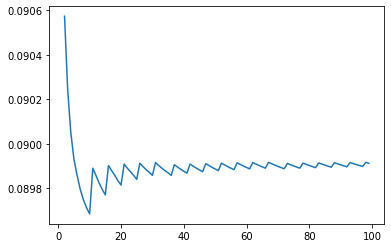

In [42]:
a1 = [el[0] for el in a]
plt.plot(n_rho, a1)

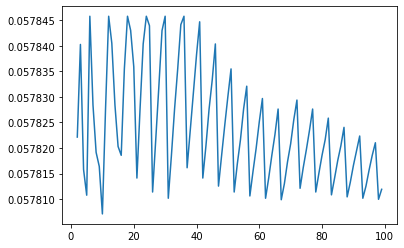

In [43]:
a2 = [el[1] for el in a]
plt.plot(n_rho, a2)

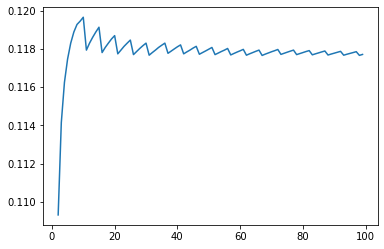

In [44]:
a3 = [el[2] for el in a]
plt.plot(n_rho, a3)

Глянемо більш детально на малі кроки із rho

In [45]:
n_rho = range(90, 100, 1)
model.integr_params.eps = 4e-3
a = [solver.integrate_trap(model.integr_params, tip_coord, tip_angle) for model.integr_params.n_rho in n_rho]

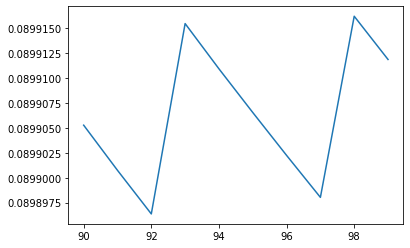

In [48]:
a1 = [el[0] for el in a]
plt.plot(n_rho, a1)

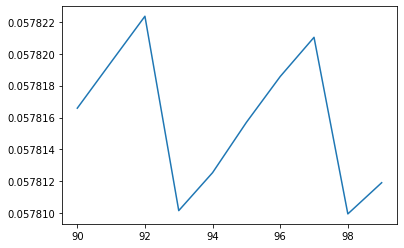

In [49]:
a2 = [el[1] for el in a]
plt.plot(n_rho, a2)

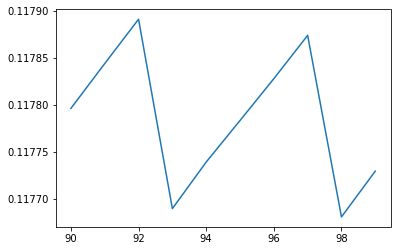

In [50]:
a3 = [el[2] for el in a]
plt.plot(n_rho, a3)

Отже ця дивна поведінка зі стрибками мабуть повязана із тим що меш привносить певно не неперервність. Мабуть варто спробувати додати кільця або лінії щоб покращити якість мешу.

Спробуємо тут покращити меш з допомогою впровадження якихось додатвоких ліній щоб покращити симетрію.

##### Додамо кругову границю

In [3]:
model = riversim.Model()
model.initializeDirichlet()
model.rivers[1].addPoint(riversim.Polar(0.1, 0), 0)
circ_around_tip_boundary = riversim.Boundary()
tip_angle = model.rivers[1].tipAngle()
tip_coord = model.rivers[1].tipPoint()
r = model.integr_params.integration_radius
n = 10
for i in range(1, n - 1):
    circ_around_tip_boundary.vertices.append(\
        tip_coord + riversim.Point( \
            r * np.cos(i / n * 2 * np.pi + tip_angle), \
            r * np.sin(i / n * 2 * np.pi + tip_angle)))
    circ_around_tip_boundary.lines.append(riversim.Line( i, i + 1, -1))
#circ_around_tip_boundary.lines[-1].p2 = 0

In [ ]:
model.rivers[1].addPoint(riversim.Polar(0.1, 0), 0)

boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, 0.00001, 0, 0)
boundary.append(circ_around_tip_boundary)
triangle = riversim.Triangle(model.mesh_params)
triangle.mesh_params.tip_points = model.rivers.tipPoints()

mesh = triangle.generate(boundary, model.region.holes)
mesh.write("trapezoid_test_with_circle.msh")
solver = riversim.Solver(model.solver_params, True)
start = time.time()
solver.openMesh(mesh)
for i in range(1 + model.solver_params.adaptive_refinment_steps):
    if i > 0:
        solver.refineGrid()
    solver.setupSystem()
    solver.assembleSystem(model.boundary_conditions)
    solver.solve()
end = time.time() - start

solver.outputResults("trapezoid_test_with_circle")

In [16]:
boundary_1 = riversim.Boundary()
boundary_1.vertices.extend([\
    riversim.Point(0, 0), riversim.Point(1, 0), \
    riversim.Point(1, 1), riversim.Point(0, 1),\
    riversim.Point(-1, 0), riversim.Point(2, 1)])
boundary_1.lines.extend([\
        riversim.Line(0, 1, 0), riversim.Line(1, 2, 0), riversim.Line(2, 3, 0), riversim.Line(3, 0, 0),\
        riversim.Line(4, 5, 0)])

boundary_2 = riversim.Boundary()
boundary_2.vertices.extend([\
    riversim.Point(0, 0), riversim.Point(0.5, 0.9), riversim.Point(1, 0), \
    riversim.Point(1, 1), riversim.Point(0, 1),\
    riversim.Point(-1, 0), riversim.Point(2, 1)])
boundary_2.lines.extend([\
        riversim.Line(0, 1, -1), riversim.Line(1, 2, -1), riversim.Line(2, 3, -1), riversim.Line(3, 4, 1), riversim.Line(4, 0, 1),\
        riversim.Line(5, 6, -1)])

mesh_params = riversim.MeshParams()
mesh_params.max_area = 0.001
triangle = riversim.Triangle(mesh_params)

holes = riversim.t_PointList()
mesh = triangle.generate(boundary_1, holes)
mesh.write("mesh_with_intersection.msh")

mesh = triangle.generate(boundary_2, holes)
mesh.write("mesh_with_intersection_2.msh")

solver_params = riversim.SolverParams()
solver = riversim.Solver(solver_params, True)
solver.openMesh(mesh)

boundary_conditions = riversim.BoundaryConditions()
boundary_conditions[1] = riversim.BoundaryCondition(riversim.DIRICHLET, 0)
for i in range(1 + solver_params.adaptive_refinment_steps):
    if i > 0:
        solver.refineGrid()
    solver.setupSystem()
    solver.assembleSystem(boundary_conditions)
    solver.solve()

solver.outputResults("trapezoid_test_with_circle")

Цей підхід не працює, навіть коли додав відємний ід границі.. помилки в генерації мешу і солвера. Меш з перетином важко працює.. а круговий завжди таким буде по суті.. 

Збіжність по детальності по кутах

### Імплементація трапеції в пайтоні

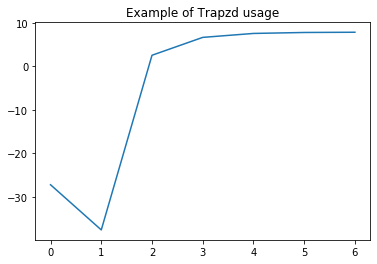

In [21]:
# integration
class Quadrature:
    def __init__(self, n):
        self.n = n
    def next():
        pass

class Trapzd(Quadrature):
  def __init__(self, func, a, b):
    self.func = func
    self.a = a
    self.b = b
    self.n = 0
    self.s = 0

  def next(self):
    self.n += 1
    if self.n == 1:
        self.s = 0.5 * (self.b - self.a) * (self.func(self.a) + self.func(self.b))
    else:
        tnm = np.power(2, self.n - 2)
        d = (self.b - self.a) / tnm
        x = self.a + 0.5 * d
        sum = 0
        for j in np.arange(0, tnm):
            sum += self.func(x)
            x += d
        self.s = 0.5 * (self.s + (self.b - self.a) * sum / tnm)

    return self.s

t = Trapzd(lambda x: x*np.sin(x), 0, 10)
I_series = [t.next() for i in range(7)]
plt.plot(I_series)
plt.title("Example of Trapzd usage")

def qtrap(func, a, b, eps = 1e-10):
    jmax = 30
    s = olds = 0
    t = Trapzd(func, a, b)
    for i in range(jmax):
        s = t.next()
        if i > 5:
            cur_eps = abs(s - olds) / abs(olds)
            if cur_eps < eps or (s < 1e-15 and olds < 1e-15):
                return (s, cur_eps, t.n)
        olds = s
    
    raise Exception('Too many steps in routine qtrap')

def qsimp(func, a, b, eps = 1e-10):
    jmax = 30
    s = st = ost = os = 0
    t = Trapzd(func, a, b)
    for i in range(jmax):
        st = t.next()
        s = (4. * st - ost) / 3.
        if i > 5:
            cur_eps = abs(s - os) / abs(os)
            if cur_eps < eps or (s == 0. and os == 0.):
                return (s, cur_eps, t.n)
        os = s
        ost = st
    
    raise Exception('Too many steps in routine qsimp')

#def qromb(func, a, b, eps = 1e-10):
#    jmax = 20
#    jmaxp = jmax + 1
#    k = 5
#    s = [0] * jmax
#    h = [0] * jmaxp
#    h[0] = 1
#    t = Trapzd(func, a, b)
#    for j in range(1, jmax):
#        s[j-1] = t.next()
#        if j >= k:
#            ss =  

def qgaus(func, a, b):
    x = [0.1488743389816312,0.4333953941292472,\
        0.6794095682990244,0.8650633666889845,0.9739065285171717]
    w = [0.2955242247147529,0.2692667193099963,\
        0.2190863625159821,0.1494513491505806,0.0666713443086881]
    xm = (b + a) / 2.
    xr = (b - a) / 2.
    s = 0
    for j in range(5):
        dx = xr * x[j]
        s += w[j] * (func(xm +dx) + func(xm - dx))
    s = s * xr
    return s


3.303494930267334
1.6215448379516602
0.0004718303680419922
7.62939453125e-05
7001.446184941889
3436.711470439616
0.1616978271854472
(3.1415926524946025, 6.374330581628277e-10, 22)
(3.1415926523800475, 7.040775529486099e-10, 21)
3.1415926535897967
3.1430279111285824
3.141592653589793
3.486099969078068e-10
1.1308638867425824e-15


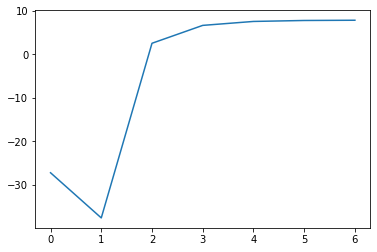

In [17]:
I_time = time.time()
I_qtrap = qtrap(lambda x: 2*np.sqrt(1 - x*x), -1, 1, 1e-9)
I_time = time.time() - I_time
I_qsimp_time = time.time()
I_qsimp = qsimp(lambda x: 2*np.sqrt(1 - x*x), -1, 1, 1e-9)
I_qsimp_time = time.time() - I_qsimp_time
I_scipy_time = time.time()
I_scipy = integrate.quad(lambda x: 2*np.sqrt(1 - x*x), -1, 1, epsrel = 1e-9)
I_scipy_time = time.time() - I_scipy_time
I_qgaus_time = time.time()
I_qgaus = qgaus(lambda x: 2*np.sqrt(1 - x*x), -1, 1)
I_qgaus_time = time.time() - I_qgaus_time

print(I_time)
print(I_qsimp_time)
print(I_scipy_time)
print(I_qgaus_time)
print(I_time/I_scipy_time)
print(I_qsimp_time/I_scipy_time)
print(I_qgaus_time/I_scipy_time)
print(I_qtrap)
print(I_qsimp)
print(I_scipy[0])
print(I_qgaus)
print(np.pi)
print(abs(np.pi - I_qtrap[0]) / I_qtrap[0])
print(abs(np.pi - I_scipy[0]) / I_scipy[0])

#### 2D Трапеція

Меш зі зіркою буде тут перевірятися

In [5]:
def v(rho, phi):
    a = solver.integral_value_res(rho, phi, tip_coord, tip_angle, model.integr_params)
    return [a[0]/a[3], a[1]/a[4], a[2]/a[5]]

def v_in(rho, phi, index):
    v_in_vect_1 = np.vectorize(lambda rho, phi: solver.integral_value_res(rho, phi, tip_coord, tip_angle, model.integr_params)[index])
    v_in_vect_2 = np.vectorize(lambda rho, phi: solver.integral_value_res(rho, phi, tip_coord, tip_angle, model.integr_params)[index + 3])   
    return v_in_vect_1(rho, phi)/v_in_vect_2(rho, phi)

print(v(0.2, 0.1))
print(v_in(0.2, 0.1, 0))

[0.08488787576843562, -1.898941733662822, 0.4287230377180623]
0.08488787576843562


/home/oleg/.local/lib/python3.8/site-packages/numpy/lib/function_base.py:2246: RuntimeWarning: divide by zero encountered in <lambda> (vectorized)
  outputs = ufunc(*inputs)
/tmp/ipykernel_25708/1773680636.py:8: RuntimeWarning: invalid value encountered in true_divide
  return v_in_vect_1(rho, phi)/v_in_vect_2(rho, phi)


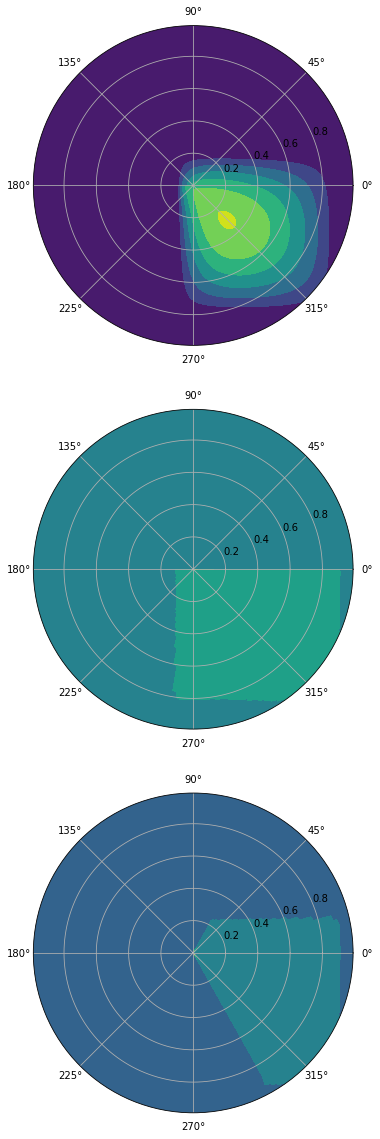

In [6]:
azimuths = np.radians(np.linspace(-180, 180, 180))
zeniths = np.arange(0, 1, 0.01)

r, theta = np.meshgrid(zeniths, azimuths)

a1 = 1
a2 = 0
a3 = 0
values = v_in(r, theta, 0)

#-- Plot... ------------------------------------------------
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots(3, 1, subplot_kw = dict(projection='polar'))
ax[0].contourf(theta, r, values)

values = v_in(r, theta, 1)
ax[1].contourf(theta, r, values)

values = v_in(r, theta, 2)
ax[2].contourf(theta, r, values)

plt.show()

## Порівняння з Аналітичним результатом

In [ ]:
model = riversim.Model()
model.height = 50
model.width = 1
model.dx = 0.5
model.ds = 0
model.initializeLaplace()
model.boundary_conditions[3].type = riversim.DIRICHLET
model.boundary_conditions[3].value = 1

h = 4
model.rivers[1].addPoint(riversim.Polar(h, 0), 0)

boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, 0.00001, 0, 0)
triangle = riversim.Triangle(model.mesh_params)
triangle.mesh_params.tip_points = model.rivers.tipPoints()

mesh = triangle.generate(boundary, model.region.holes)

solver = riversim.Solver(model.solver_params, False)
solver.openMesh(mesh)
for i in range(1 + model.solver_params.adaptive_refinment_steps):
    if i > 0:
        solver.refineGrid()
    solver.setupSystem()
    solver.assembleSystem(model.boundary_conditions)
    solver.solve()

tip_angle = model.rivers[1].tipAngle()
tip_coord = model.rivers[1].tipPoint()

series_params_old = solver.integrate(model.integr_params, tip_coord, tip_angle)
series_params_new = solver.integrate_new(model.integr_params, tip_coord, tip_angle)
model.integr_params.eps = 5e-3
series_params_trap = solver.integrate_trap(model.integr_params, tip_coord, tip_angle)

print(series_params_old[0])
print(series_params_new[0])
print(series_params_trap[0])
print(np.sqrt(4/np.pi*np.tanh(np.pi/2 * h)))

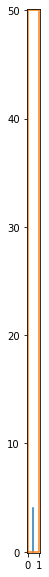

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plot(fig, ax, model)

## Різне

In [8]:
integral_l = integrate.dblquad(integral_l_func, 0., 2.*np.pi, 0., model.integr_params.integration_radius, epsabs=1e-14)
normalization_l = integrate.dblquad(normalization_l_func, 0., 2.*np.pi, 0, model.integr_params.integration_radius, epsabs=1e-14)
a2 = integral_l[0]/normalization_l[0]
print("integral = " + str(integral_l[0]))
print("normalization = " + str(normalization_l[0]))
print(a2)
print(series_params_orig[1])
print("error = " + str(a2/series_params_orig[1]))

/home/oleg/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/home/oleg/.local/lib/python3.8/site-packages/scipy/integrate/_quadpack_py.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


integral = 9.071697037860584e-10
normalization = 1.568857810125399e-08
0.057823576995390556
0.057802788358728034
error = 1.0003596476442194


In [12]:
test_int_1 = integrate.dblquad(lambda phi_1, rho_1: rho_1, 0., 2.*np.pi, 0., 1)
test_int_2 = integrate.dblquad(lambda rho_1, phi_1: rho_1, 0., 2.*np.pi, 0., 1)
#test_int_3 = integrate.dblquad(lambda rho_1, phi_1: np.array([1, 1, 1]), 0., 1, 0., 1)
print(test_int_1)
print(test_int_2)
#print(test_int_3)
print(np.pi * np.power(model.integr_params.integration_radius, 2))
print(2.*np.pi)

(19.739208802178716, 2.1914924100062368e-13)
(3.141592653589793, 3.487868498008632e-14)
0.0028274333882308137
6.283185307179586


In [3]:
model = riversim.Model()
n = 8
m = 4200
result = seriesParamsEvaluation(model, n, m)
print(result)

{'averageSolverError': 7.606431220968564e-05, 'maxSolverError': 0.0007592121255584061, 'seriesParamsOrig': [0.0906574888281114, 0.057802788358728034, 0.11243172053173604], 'seriesParamsMy': [0.09065711441798233, 0.05780278835875238, 0.11106826338192946], 'dof': 8779, 'numberOfCells': 960}


Отже.. які збіжності ми хочемо перевірити?
 - Помилка самого солвера фем
 - розмір сітки
 - кількість поділів при обрахунку інтегралу

In [ ]:
model = riversim.Model()
model.initializeDirichlet()
model.solver_params.adaptive_refinment_steps = 20

adaptive_steps = np.arange(model.solver_params.adaptive_refinment_steps + 1)
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
dof = []
cells = []

model.rivers[1].addPoint(riversim.Polar(0.1, 0), 0)

boundary = riversim.BoundaryGenerator(model.sources, model.region, model.rivers, 0.00001, 0, 0)
triangle = riversim.Triangle(model.mesh_params)
triangle.mesh_params.tip_points = model.rivers.tipPoints()

mesh = triangle.generate(boundary, model.region.holes)

solver = riversim.Solver(model.solver_params, True)
solver.openMesh(mesh)
for i in range(1 + model.solver_params.adaptive_refinment_steps):
    if i > 0:
        solver.refineGrid()
    solver.setupSystem()
    solver.assembleSystem(model.boundary_conditions)
    solver.solve()

    tip_angle = model.rivers[1].tipAngle()
    tip_coord = model.rivers[1].tipPoint()
    series_params_orig = solver.integrate_new(model.integr_params, tip_coord, tip_angle)

    integral = [0, 0, 0]
    normalization = [0, 0, 0]
    drho = model.integr_params.integration_radius / n
    for rho in np.arange(drho, model.integr_params.integration_radius, drho):
        weight_func_value = model.integr_params.weightFunction(rho)
        for phi in np.arange(0, 2 * np.pi, np.pi / m / rho * model.integr_params.integration_radius):
            cylind_coord = riversim.Polar(rho, phi)
            abs_coord = riversim.Point(tip_coord.x + rho * np.cos(phi + tip_angle), tip_coord.y + rho * np.sin(phi + tip_angle))
            rel_coord = abs_coord - tip_coord
            try:
                sol_value = solver.value(abs_coord)
            except:
                continue

            for param_index in range(3):
                base_vector_value = model.integr_params.baseVectorFinal(param_index + 1, tip_angle, rel_coord.x, rel_coord.y);
                integral[param_index] += sol_value * weight_func_value * base_vector_value * rho
                normalization[param_index] += weight_func_value * np.power(base_vector_value, 2) * rho

    series_params_my = [integ / norm for integ, norm in zip(integral, normalization)]
    solver.outputResults("integral_research")

    result = {"averageSolverError": solver.averageCellError(),
            "maxSolverError": solver.maxCellError(), 
            "seriesParamsOrig": [series_params_orig[0], series_params_orig[1], series_params_orig[2]],
            "seriesParamsMy": series_params_my, 
            "dof": solver.numberOfDOFs(),
            "numberOfCells": solver.numberOfCells()}
    print(i)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])

Text(0.5, 113.99999999999989, 'number of adaptive steps')

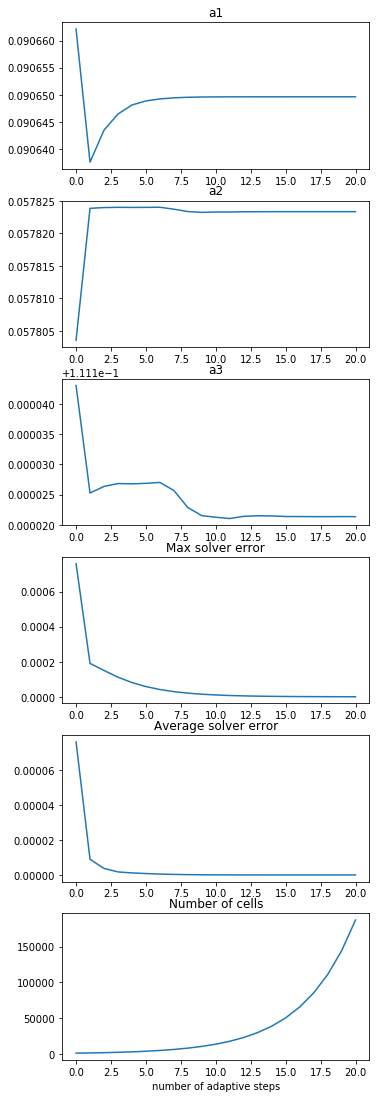

In [47]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(adaptive_steps, series_param_1)
ax[0].set_title("a1")
ax[1].plot(adaptive_steps, series_param_2)
ax[1].set_title("a2")
ax[2].plot(adaptive_steps, series_param_3)
ax[2].set_title("a3")
ax[3].plot(adaptive_steps, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(adaptive_steps, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(adaptive_steps, cells)
ax[5].set_title("Number of cells")
ax[5].set_xlabel("number of adaptive steps")

Отже на всіх графіках однозначно видно збіжність.

In [49]:
print(series_param_1)
print(series_param_2)
print(series_param_3)
print(max_solver_error)
print(avrg_solver_error)
print(cells)
print(series_param_1[0])
print(series_param_1[-1])
print(series_param_2[0])
print(series_param_2[-1])
print(series_param_3[0])
print(series_param_3[-1])
print(max_solver_error[0])
print(max_solver_error[-1])
print(avrg_solver_error[0])
print(avrg_solver_error[-1])
print(cells[0])
print(cells[-1])

[0.0906621248360517, 0.09063755967112297, 0.09064346569551363, 0.09064643629444243, 0.09064810500647205, 0.09064886268209482, 0.09064922355313179, 0.09064943014122642, 0.09064953497857937, 0.09064958181250256, 0.09064960425871763, 0.09064961503532187, 0.0906496164889809, 0.09064961891927951, 0.09064962068789499, 0.09064962208272465, 0.0906496225338238, 0.09064962267721396, 0.09064962278156673, 0.09064962288474514, 0.09064962290127289]
[0.05780355059070401, 0.05782385331843312, 0.05782396972173536, 0.057824007324163255, 0.05782399115826438, 0.05782400040516402, 0.05782401913168716, 0.057823721156931976, 0.0578233565685546, 0.057823229778724436, 0.05782329114477852, 0.05782328781245319, 0.05782332394016378, 0.057823332435981256, 0.05782333698935704, 0.05782334368230641, 0.05782334295600021, 0.05782334071473288, 0.057823340040938136, 0.057823340176284856, 0.05782334023098132]
[0.11114309403935013, 0.1111252681124333, 0.11112636022698988, 0.11112683783232248, 0.11112678874353732, 0.1111268

Тепер розглянемо збіжність просто по самому солверу.

In [75]:
model = riversim.Model()
tolerance = [1e-10, 1e-11, 1e-12, 1e-13, 1e-14]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.solver_params.tollerance in tolerance:
    result = seriesParamsEvaluation(model, 8, 4200)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])

Text(0.5, 113.99999999999989, 'tollerance')

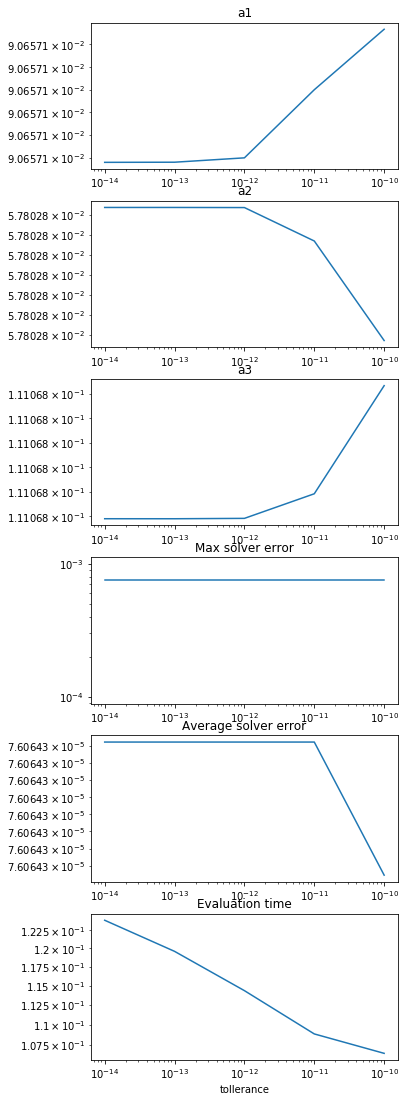

In [76]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].loglog(tolerance, series_param_1)
ax[0].set_title("a1")
ax[1].loglog(tolerance, series_param_2)
ax[1].set_title("a2")
ax[2].loglog(tolerance, series_param_3)
ax[2].set_title("a3")
ax[3].loglog(tolerance, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].loglog(tolerance, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].loglog(tolerance, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("tollerance")

In [78]:
series_param_3[0] - series_param_3[-1]

1.0883795392713225e-09

Тепер спорбує глянути як змінююється розвязок в залежності від порядку скінченного елементу.

In [90]:
model = riversim.Model()
model.solver_params.tollerance = 1e-15
quadrature_degree = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.solver_params.quadrature_degree in quadrature_degree:
    result = seriesParamsEvaluation(model, 8, 4200)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])

Text(0.5, 113.99999999999989, 'quadrature degree')

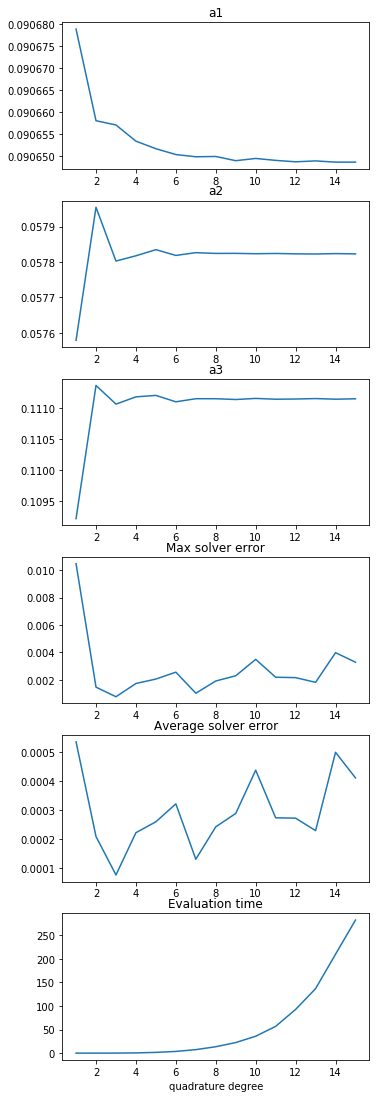

In [86]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(quadrature_degree, series_param_1)
ax[0].set_title("a1")
ax[1].plot(quadrature_degree, series_param_2)
ax[1].set_title("a2")
ax[2].plot(quadrature_degree, series_param_3)
ax[2].set_title("a3")
ax[3].plot(quadrature_degree, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(quadrature_degree, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(quadrature_degree, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("quadrature degree")

In [88]:
print(series_param_1[-1])
print(series_param_2[-1])
print(series_param_3[-1])

0.09064865177866797
0.0578230643110854
0.11115436826223413


Text(0.5, 113.99999999999989, 'quadrature degree')

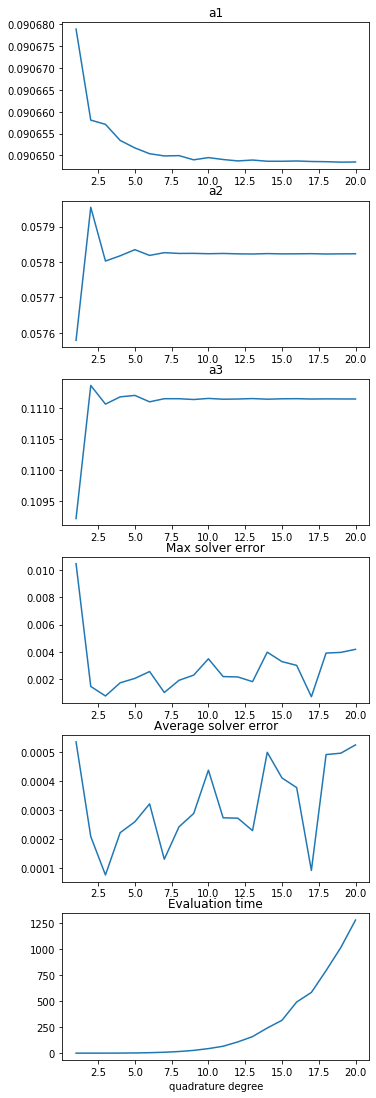

In [91]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(quadrature_degree, series_param_1)
ax[0].set_title("a1")
ax[1].plot(quadrature_degree, series_param_2)
ax[1].set_title("a2")
ax[2].plot(quadrature_degree, series_param_3)
ax[2].set_title("a3")
ax[3].plot(quadrature_degree, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(quadrature_degree, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(quadrature_degree, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("quadrature degree")

Розмір мешу тепер будемо змінювати

In [3]:
model = riversim.Model()
model.solver_params.tollerance = 1e-15
quadrature_degree = [1, 2, 3, 4]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.solver_params.quadrature_degree in quadrature_degree:
    result = seriesParamsEvaluation(model, 8, 4200)
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])

In [4]:
model.integr_params.integration_radius

0.03

In [5]:
model.mesh_params.refinment_radius

0.005

In [23]:
print(model.mesh_params)
print(model.integr_params)

{
    "exponant": 1.0,
    "ignored_smoothness_length": 0.05,
    "max_area": 100000.0,
    "max_edge": 1.0,
    "min_angle": 32.0,
    "min_area": 6e-07,
    "min_edge": 8e-12,
    "ratio": 2.3,
    "refinment_radius": 0.005,
    "sigma": 1.9,
    "smoothness_degree": 0.5
}
{
    "exponant": 2.0,
    "integration_radius": 0.03,
    "weigth_func_radius": 0.01
}


0.03


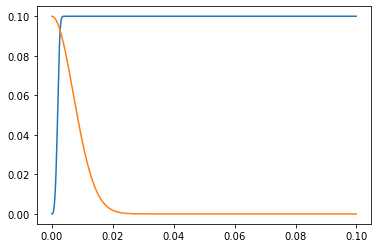

In [37]:
model = riversim.Model()
model.mesh_params.tip_points.append(riversim.Point(0, 0))
model.mesh_params.sigma = 0.005
model.mesh_params.exponant = 3
model.mesh_params.min_area = 6e-10
model.mesh_params.max_area = 1e-1
model.mesh_params.min_edge = 1e-13
model.mesh_params.refinment_radius = 0.05
print(model.integr_params.integration_radius)
r = np.arange(0, 0.1, 0.0001)
areaFunc = [model.mesh_params.meshAreaConstraint(x, 0) for x in r]
weightFunc = [0.1*model.integr_params.weightFunction(x) for x in r]
plt.plot(r, areaFunc, r, weightFunc)

In [31]:


model.solver_params.tollerance = 1e-15
model.solver_params.quadrature_degree = 7
sigma = [0.005, 4]
series_param_1 = []
series_param_2 = []
series_param_3 = []
max_solver_error = []
avrg_solver_error = []
t = []
dof = []
cells = []
for model.mesh_params.sigma in sigma:
    print(model.mesh_params.sigma)

    result = seriesParamsEvaluation(model, 8, 4200)
    
    series_param_1.append(result["seriesParamsMy"][0])
    series_param_2.append(result["seriesParamsMy"][1])
    series_param_3.append(result["seriesParamsMy"][2])
    max_solver_error.append(result["maxSolverError"])
    avrg_solver_error.append(result["averageSolverError"])
    dof.append(result["dof"])
    cells.append(result["numberOfCells"])
    t.append(result["solverTime"])


0.005
4.0


Text(0.5, 113.99999999999989, 'sigma')

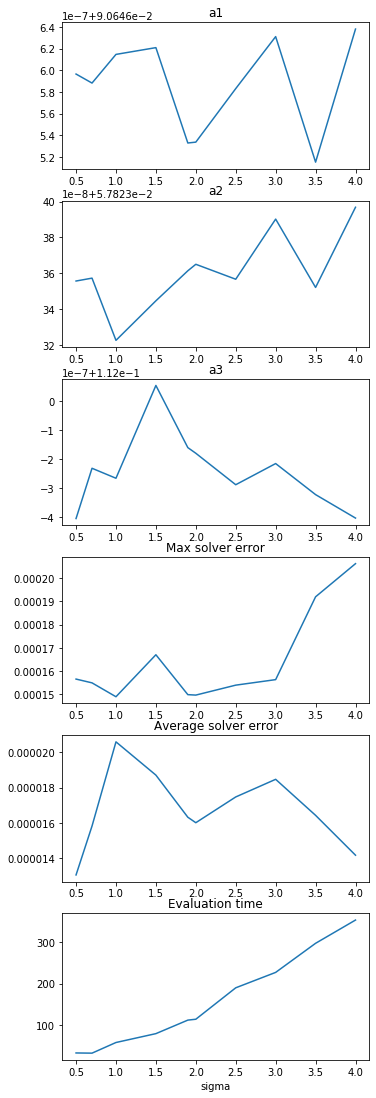

In [64]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(sigma, series_param_1)
ax[0].set_title("a1")
ax[1].plot(sigma, series_param_2)
ax[1].set_title("a2")
ax[2].plot(sigma, series_param_3)
ax[2].set_title("a3")
ax[3].plot(sigma, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(sigma, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(sigma, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("sigma")

In [66]:
print(series_param_1[-1])
print(series_param_2[-1])
print(series_param_3[-1])

0.09064663809200912
0.05782339680416207
0.1119995961500431


Text(0.5, 113.99999999999989, 'sigma')

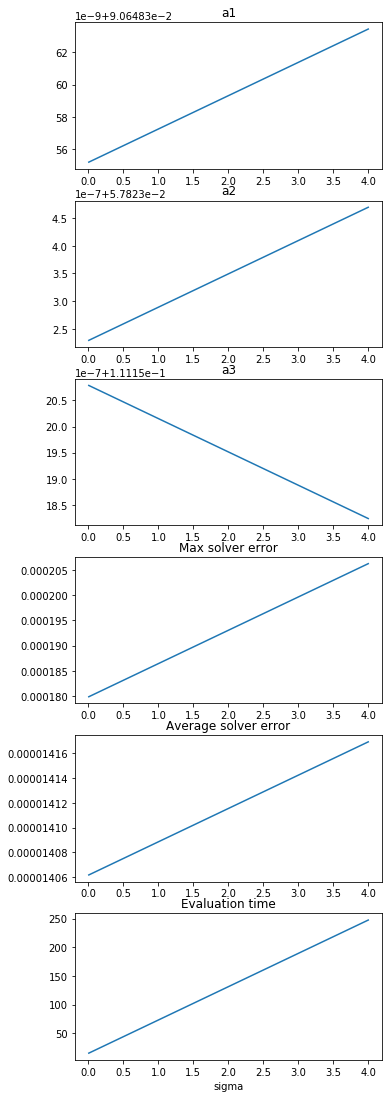

In [38]:
fig, ax = plt.subplots(6, 1, figsize=(5, 15))
fig.tight_layout()

ax[0].plot(sigma, series_param_1)
ax[0].set_title("a1")
ax[1].plot(sigma, series_param_2)
ax[1].set_title("a2")
ax[2].plot(sigma, series_param_3)
ax[2].set_title("a3")
ax[3].plot(sigma, max_solver_error)
ax[3].set_title("Max solver error")
ax[4].plot(sigma, avrg_solver_error)
ax[4].set_title("Average solver error")
ax[5].plot(sigma, t)
ax[5].set_title("Evaluation time")
ax[5].set_xlabel("sigma")

In [32]:
series_param_1

[0.09064835520531252, 0.09064836342677941]